# AI中医——望诊

## 关闭当前模型和优化器

In [1]:
import os
import gc
import torch

# 关闭当前模型和优化器
del model
del trainer
gc.collect()
torch.cuda.empty_cache()

NameError: name 'model' is not defined

In [2]:
import os

# 替换为你实际看到的 PID
pid = 24325

# 杀掉进程
os.system(f"kill -9 {pid}")


256

In [3]:
import gc
import torch

gc.collect()
torch.cuda.empty_cache()


In [4]:
!nvidia-smi

Thu Jun 12 12:45:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             42W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

## 减少碎片



In [5]:
%env PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True

env: PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True


In [6]:
import os

# 设置 PyTorch 的 CUDA 内存分配配置，以减少碎片
# 这必须在导入 torch 之前设置
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

# import torch

# 在这里继续您其他的 import 和代码
# ...

# 加载数据

In [7]:
# 1: 授权并挂载你的 Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 这会在 Colab 的文件系统中创建一个名为 'drive' 的快捷方式
# 它的路径是 /content/drive/MyDrive/，指向你的 Google Drive "我的云端硬盘"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


（可选）注意不要replace

In [8]:
# 2: 将数据集从 Drive 解压到 Colab 本地环境
# 假设你把 zip 文件上传到了 Drive 的根目录
# 使用 !unzip 命令进行解压
# -q 参数表示 'quiet'，即静默模式，不会打印出成千上万个解压的文件名，让输出更整洁
# -d 参数指定解压到的目标文件夹

# 强烈建议解压到 /content/ 目录下，因为本地读取速度远快于直接从挂载的 Drive 读取
!unzip -q /content/drive/MyDrive/facial-dataset-of-autistic-children.zip -d /content/facial-dataset-of-autistic-children/

print("数据集解压完成！")

数据集解压完成！


In [8]:
# 现在你可以 ls 查看一下，数据已经准备好了
!ls /content/facial-dataset-of-autistic-children/

test  test.csv	train  train.csv  val  val.csv


In [9]:
from datasets import Dataset, DatasetDict, Features, Value, Image
import pandas as pd
import os

base_path = "/content/facial-dataset-of-autistic-children"

def label_to_text(label):
    return f"问：这张面部照片属于自闭症儿童吗？答：{'是的。' if label.lower() == 'autistic' else '不是。'}"

def load_split(split):
    df = pd.read_csv(os.path.join(base_path, f"{split}.csv"))

    # 替换反斜杠为正斜杠（Windows -> Linux）
    df["image"] = df["image"].apply(lambda x: x.replace("\\", "/"))

    # 拼接绝对路径
    df["Image"] = df["image"].apply(lambda x: os.path.join(base_path, x))

    # 文本指令格式
    df["text"] = df["label"].apply(label_to_text)

    # 定义 features：image 字段必须是 Image 类型！
    features = Features({
        "Image": Image(),  # 这行非常关键！
        "text": Value("string"),
        "image": Value("string"),
        "label": Value("string")
    })

    return Dataset.from_pandas(df, features=features)

In [10]:
data = DatasetDict({
    "train": load_split("train"),
    "validation": load_split("val"),
    "test": load_split("test")
})

In [11]:
data

DatasetDict({
    train: Dataset({
        features: ['Image', 'text', 'image', 'label'],
        num_rows: 1737
    })
    validation: Dataset({
        features: ['Image', 'text', 'image', 'label'],
        num_rows: 580
    })
    test: Dataset({
        features: ['Image', 'text', 'image', 'label'],
        num_rows: 580
    })
})

（可选）在处理模型微调和评估流程时，先用一小部分数据跑通流程是非常高效和稳妥的做法。

In [ ]:
# 在处理模型微调和评估流程时，先用一小部分数据跑通流程是非常高效和稳妥的做法。
data = DatasetDict({
    "train": data["train"].shuffle(seed=42).select(range(10)),
    "validation": data["validation"].shuffle(seed=42).select(range(10)),
    "test": data["test"].shuffle(seed=42).select(range(10)),
})
print(data)

DatasetDict({
    train: Dataset({
        features: ['Image', 'text', 'image', 'label'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['Image', 'text', 'image', 'label'],
        num_rows: 10
    })
    test: Dataset({
        features: ['Image', 'text', 'image', 'label'],
        num_rows: 10
    })
})


In [13]:
example = data["train"][0]
example

{'Image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=470x590>,
 'text': '问：这张面部照片属于自闭症儿童吗？答：是的。',
 'image': 'train/Autistic/0001.jpg',
 'label': 'Autistic'}

In [ ]:
print(example["text"])

问：这张面部照片属于自闭症儿童吗？答：是的。


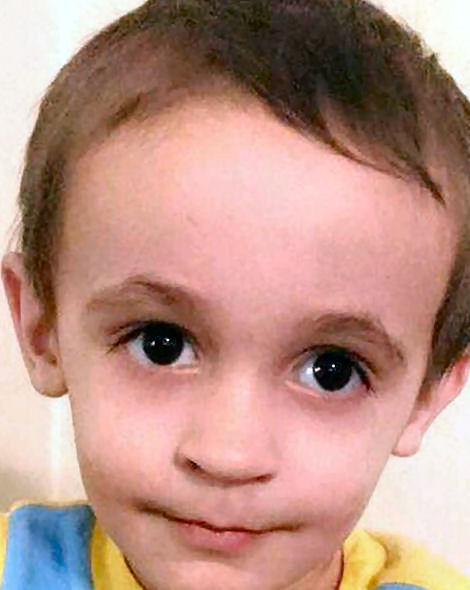

In [ ]:
example["Image"]

#### Install dependencies

In [12]:
! pip install --upgrade --quiet bitsandbytes datasets evaluate peft tensorboard transformers trl

# 数据预处理

In [13]:
from typing import Any
from datasets import ClassLabel, DatasetDict
from PIL import Image
import evaluate

In [14]:
# Define your class labels
AUTISTIC_CLASSES = [
    "0: Autistic",
    "1: Non_Autistic"
]

# Prompt to be used for each image
options = "\n".join(AUTISTIC_CLASSES)
PROMPT = f"请判断这张面部照片是否属于自闭症儿童？\n{options}"

In [15]:
# Function to convert dataset entries to the MedGemma format
def convert_to_medgemma_format(example):
    # 从文本中拆分问答部分
    question_part = example["text"].split("答：")[0].replace("问：", "").strip()
    answer_part = example["text"].split("答：")[1].strip()
    label_text = AUTISTIC_CLASSES[0] if example["label"] == "Autistic" else AUTISTIC_CLASSES[1]

    return {
        "Image": example["Image"],  # 必须是 PIL.Image
        "label": 0 if example["label"] == 'Autistic' else 1,
        "messages": [
            {
                "role": "user",
                "content": [
                    {"type": "image"},
                    {"type": "text", "text": PROMPT}
                ]
            },
            {
                "role": "assistant",
                "content": [
                    {"type": "text", "text": label_text}
                ]
            }
        ]
    }

In [16]:
data = data.map(convert_to_medgemma_format, remove_columns=data["train"].column_names)

Map:   0%|          | 0/1737 [00:00<?, ? examples/s]

Map:   0%|          | 0/580 [00:00<?, ? examples/s]

Map:   0%|          | 0/580 [00:00<?, ? examples/s]

In [17]:
data

DatasetDict({
    train: Dataset({
        features: ['Image', 'label', 'messages'],
        num_rows: 1737
    })
    validation: Dataset({
        features: ['Image', 'label', 'messages'],
        num_rows: 580
    })
    test: Dataset({
        features: ['Image', 'label', 'messages'],
        num_rows: 580
    })
})

In [20]:
sample = data["train"][0]
sample

{'Image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=470x590>,
 'label': 0,
 'messages': [{'content': [{'text': None, 'type': 'image'},
    {'text': '请判断这张面部照片是否属于自闭症儿童？\n0: Autistic\n1: Non_Autistic',
     'type': 'text'}],
   'role': 'user'},
  {'content': [{'text': '0: Autistic', 'type': 'text'}], 'role': 'assistant'}]}

In [21]:
type(sample["Image"])  # 应为 <class 'PIL.Image.Image'>

PIL.JpegImagePlugin.JpegImageFile

In [22]:
sample["messages"]     # 应该包含 user 和 assistant 的结构

[{'content': [{'text': None, 'type': 'image'},
   {'text': '请判断这张面部照片是否属于自闭症儿童？\n0: Autistic\n1: Non_Autistic',
    'type': 'text'}],
  'role': 'user'},
 {'content': [{'text': '0: Autistic', 'type': 'text'}], 'role': 'assistant'}]

完整流程：加载 .csv → 加载图像 → 构建 messages → 得到用于 Med-GEMMA 微调的 DatasetDict。

# 加载模型

#### Configure your HF token

Generate a Hugging Face `write` access token by going to [settings](https://huggingface.co/settings/tokens). **Note:** Make sure that the token has write access to push the fine-tuned model to Hugging Face Hub.

If you are using Google Colab, add your access token to the Colab Secrets manager to securely store it. If not, proceed to run the cell below to authenticate with Hugging Face.

1. Open your Google Colab notebook and click on the 🔑 Secrets tab in the left panel. <img src="https://storage.googleapis.com/generativeai-downloads/images/secrets.jpg" alt="The Secrets tab is found on the left panel." width=50%>
2. Create a new secret with the name `HF_TOKEN`.
3. Copy/paste your token key into the Value input box of `HF_TOKEN`.
4. Toggle the button on the left to allow notebook access to the secret.

In [18]:
import os
import sys

if "google.colab" in sys.modules and not os.environ.get("VERTEX_PRODUCT"):
    # Use secret if running in Google Colab
    from google.colab import userdata
    os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")
else:
    # Store Hugging Face data under `/content` if running in Colab Enterprise
    if os.environ.get("VERTEX_PRODUCT") == "COLAB_ENTERPRISE":
        os.environ["HF_HOME"] = "/content/hf"
    # Authenticate with Hugging Face
    from huggingface_hub import get_token
    if get_token() is None:
        from huggingface_hub import notebook_login
        notebook_login()

### Load model from Hugging Face Hub

In [19]:
import torch
from transformers import AutoProcessor, AutoModelForImageTextToText, BitsAndBytesConfig

model_id = "google/medgemma-4b-it"

# Check if GPU supports bfloat16
if torch.cuda.get_device_capability()[0] < 8:
    raise ValueError("GPU does not support bfloat16, please use a GPU that supports bfloat16.")

model_kwargs = dict(
    attn_implementation="eager",
    torch_dtype=torch.bfloat16,
    device_map="auto",
)

model_kwargs["quantization_config"] = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=model_kwargs["torch_dtype"],
    bnb_4bit_quant_storage=model_kwargs["torch_dtype"],
)

model = AutoModelForImageTextToText.from_pretrained(model_id, **model_kwargs)
processor = AutoProcessor.from_pretrained(model_id)

# Use right padding to avoid issues during training
processor.tokenizer.padding_side = "right"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


### Set up for fine-tuning 微调设置

In [20]:
from peft import LoraConfig

peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    target_modules="all-linear",
    task_type="CAUSAL_LM",
    modules_to_save=[
        "lm_head",
        "embed_tokens",
    ],
)

In [21]:
from typing import Any
from transformers import AutoImageProcessor

def collate_fn(examples: list[dict[str, Any]]):
    texts = []
    images = []
    for example in examples:
        images.append([example["Image"].convert("RGB")])
        texts.append(processor.apply_chat_template(
            example["messages"], add_generation_prompt=False, tokenize=False
        ).strip())

    # image size
    image_processor = AutoImageProcessor.from_pretrained("google/medgemma-4b-pt")
    # Tokenize the texts and process the images
    batch = processor(text=texts, images=images, return_tensors="pt", padding=True)

    # The labels are the input_ids, with the padding and image tokens masked in
    # the loss computation
    labels = batch["input_ids"].clone()

    # Mask image tokens
    image_token_id = [
        processor.tokenizer.convert_tokens_to_ids(
            processor.tokenizer.special_tokens_map["boi_token"]
        )
    ]
    # Mask tokens that are not used in the loss computation
    labels[labels == processor.tokenizer.pad_token_id] = -100
    labels[labels == image_token_id] = -100
    labels[labels == 262144] = -100

    batch["labels"] = labels
    return batch

Configure training parameters in an [`SFTConfig`](https://huggingface.co/docs/trl/sft_trainer#trl.SFTConfig).

In [22]:
from trl import SFTConfig

num_train_epochs = 5  # @param {type: "number"}
learning_rate = 2e-4  # @param {type: "number"}

args = SFTConfig(
    output_dir="medgemma-4b-pt-sft-qlora-fac3k",            # Directory and Hub repository id to save the model to
    num_train_epochs=num_train_epochs,                       # Number of training epochs
    per_device_train_batch_size=1,                           # Batch size per device during training
    per_device_eval_batch_size=4,                            # Batch size per device during evaluation
    gradient_accumulation_steps=4,                           # Number of steps before performing a backward/update pass
    gradient_checkpointing=True,                             # Enable gradient checkpointing to reduce memory usage
    save_steps=200,
    optim="adamw_torch_fused",                               # Use fused AdamW optimizer for better performance
    logging_steps=50,                                        # Number of steps between logs
    save_strategy="epoch",                                   # Save checkpoint every epoch
    eval_strategy="steps",                                   # Evaluate every `eval_steps`
    eval_steps=200,                                           # Number of steps between evaluations
    learning_rate=learning_rate,                             # Learning rate based on QLoRA paper
    bf16=True,                                               # Use bfloat16 precision
    save_total_limit=1,
    report_to="none",
    max_grad_norm=0.3,                                       # Max gradient norm based on QLoRA paper
    warmup_ratio=0.03,                                       # Warmup ratio based on QLoRA paper
    lr_scheduler_type="linear",                              # Use linear learning rate scheduler
    push_to_hub=True,                                        # Push model to Hub
    # report_to="tensorboard",                                 # Report metrics to tensorboard
    gradient_checkpointing_kwargs={"use_reentrant": False},  # Set gradient checkpointing to non-reentrant to avoid issues
    dataset_kwargs={"skip_prepare_dataset": True},           # Skip default dataset preparation to preprocess manually
    remove_unused_columns = False,                           # Columns are unused for training but needed for data collator
    label_names=["labels"],                                  # Input keys that correspond to the labels
)

## Fine-tune the model with QLoRA

Traditional fine-tuning of large language models is resource-intensive because it requires adjusting billions of parameters. Parameter-Efficient Fine-Tuning (PEFT) addresses this by training a smaller number of parameters. A common PEFT technique is Low-Rank Adaptation (LoRA), which efficiently adapts large language models by training small, low-rank matrices that are added to the original model instead of updating the full-weight matrices. In QLoRA, the base model is quantized to 4-bit before its weights are frozen, then LoRA adapter layers are attached and trained.

This notebook demonstrates supervised fine-tuning MedGemma with QLoRA using the `SFTTrainer` from the Hugging Face `TRL` library.

In [23]:
from trl import SFTTrainer

trainer = SFTTrainer(
    model=model,
    args=args,
    train_dataset=data["train"],
    eval_dataset=data["validation"].shuffle().select(range(200)),  # Use subset of validation set for faster run
    # eval_dataset=data["validation"].shuffle().select(range(5)),  # Use subset of validation set for faster run
    peft_config=peft_config,
    processing_class=processor,
    data_collator=collate_fn,
)

In [ ]:
trainer.train()

`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss


In [ ]:
trainer.save_model()

No files have been modified since last commit. Skipping to prevent empty commit.


In [ ]:
del model
del trainer
torch.cuda.empty_cache()

## Evaluate the fine-tuned model

Load the accuracy and F1 score metrics to evaluate the model's performance on the classfication task.

In [ ]:
test_data = data["test"]
test_data = test_data.cast_column("label", ClassLabel(names=AUTISTIC_CLASSES))
LABEL_FEATURE = test_data.features["label"]

# Alternative label format mapping
ALT_LABELS = dict([
    (label, f"({label.replace(': ', ') ')}") for label in AUTISTIC_CLASSES
])

# Post-processing function to extract predicted label

def postprocess(prediction: list[dict[str, str]], do_full_match: bool=False) -> int:
    response_text = prediction[0]["generated_text"]
    if do_full_match:
        return LABEL_FEATURE.str2int(response_text)
    for label in AUTISTIC_CLASSES:
        if label in response_text or ALT_LABELS[label] in response_text:
            return LABEL_FEATURE.str2int(label)
    return -1

Casting the dataset:   0%|          | 0/10 [00:00<?, ? examples/s]

In [ ]:
import evaluate

# Metrics
accuracy_metric = evaluate.load("accuracy")
f1_metric = evaluate.load("f1")

# Ground-truth labels
REFERENCES = test_data["label"]

# Metric computation
def compute_metrics(predictions: list[int]) -> dict[str, float]:
    metrics = {}
    metrics.update(accuracy_metric.compute(
        predictions=predictions,
        references=REFERENCES,
    ))
    metrics.update(f1_metric.compute(
        predictions=predictions,
        references=REFERENCES,
        average="weighted",
    ))
    return metrics

Define a postprocessing function to convert responses to integer class labels before computing metrics.

In [ ]:
from datasets import ClassLabel

# Rename the class names to the tissue classes, `X: tissue type`
test_data = test_data.cast_column(
    "label",
    ClassLabel(names=AUTISTIC_CLASSES)
)

LABEL_FEATURE = test_data.features["label"]
# Mapping to alternative label format, `(X) tissue type`
ALT_LABELS = dict([
    (label, f"({label.replace(': ', ') ')}") for label in AUTISTIC_CLASSES
])


def postprocess(prediction: list[dict[str, str]], do_full_match: bool=False) -> int:
    response_text = prediction[0]["generated_text"].strip().lower()
    if do_full_match:
      try:
        return LABEL_FEATURE.str2int(response_text)
      except:
        return -1  # 无效预测
    if "autistic" in response_text or "是" in response_text:
        return LABEL_FEATURE.str2int("0: Autistic")
    elif "non_autistic" in response_text or "不是" in response_text:
        return LABEL_FEATURE.str2int("1: Non_Autistic")
    else:
        return -1  # 无法识别的输出

Casting the dataset:   0%|          | 0/10 [00:00<?, ? examples/s]

### Compute baseline metrics on the pretrained model

Load the pretrained model using the `pipeline` API.

In [ ]:
from transformers import pipeline

pt_pipe = pipeline(
    "image-text-to-text",
    model=model_id,
    torch_dtype=torch.bfloat16,
)

# Set `do_sample = False` for deterministic responses
pt_pipe.model.generation_config.do_sample = False
pt_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Run batch inference on the test dataset.

In [ ]:
pt_outputs = pt_pipe(
    text=test_data["messages"],
    images=test_data["Image"],
    max_new_tokens=40,
    batch_size=64,
    return_full_text=False,
)

pt_predictions = [postprocess(out) for out in pt_outputs]

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


Compute metrics.

In [ ]:
pt_metrics = compute_metrics(pt_predictions)
print(f"Baseline metrics: {pt_metrics}")

Baseline metrics: {'accuracy': 0.0, 'f1': 0.0}


### Compute metrics on the fine-tuned model

Load the base model with the fine-tuned LoRA adapter using the pipeline API.

In [ ]:
ft_pipe = pipeline(
    "image-text-to-text",
    model=args.output_dir,
    processor=processor,
    torch_dtype=torch.bfloat16,
)

# Set `do_sample = False` for deterministic responses
ft_pipe.model.generation_config.do_sample = False
ft_pipe.model.generation_config.pad_token_id = processor.tokenizer.eos_token_id
# Use left padding during inference
processor.tokenizer.padding_side = "left"

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Run batch inference on the test dataset.

In [ ]:
ft_outputs = ft_pipe(
    text=test_data["messages"],
    images=test_data["Image"],
    max_new_tokens=20,
    batch_size=8,
    return_full_text=False,
)

for i, out in enumerate(ft_outputs):
    print(f"[{i}] Prediction: {out}")

# 处理预测结果为整数 label
ft_predictions = [postprocess(out, do_full_match=False) for out in ft_outputs]

# 评估
compute_metrics(ft_predictions)

The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['top_p', 'top_k']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
W0611 16:30:30.943000 2224 torch/_dynamo/convert_frame.py:906] [0/8] torch._dynamo hit config.cache_size_limit (8)
W0611 16:30:30.943000 2224 torch/_dynamo/convert_frame.py:906] [0/8]    function: 'forward' (/usr/local/lib/python3.11/dist-packages/transformers/models/gemma3/modeling_gemma3.py:1275)
W0611 16:30:30.943000 2224 torch/_dynamo/convert_frame.py:906] [0/8]    last reason: 0/7: Cache line invalidated because L['past_key_values'].key_cache[33] got deallocated
W0611 16:30:30.943000 2224 torch/_dynamo/convert_frame.py:906] [0/8] To log all recompilation reasons, use TORCH_LOGS="recompiles".
W0611 16:30:30.943000 2224 torch/_dynamo/convert_frame.py:906] [0/8] To diagnose recompilation issues, see https://pytorch

RecompileLimitExceeded: cache_size_limit reached

Compute metrics.

In [ ]:
ft_metrics = compute_metrics(ft_predictions)
print(f"Fine-tuned metrics: {ft_metrics}")

Fine-tuned metrics: {'accuracy': 0.0, 'f1': 0.0}


# 太棒了！微调后模型的准确率从XXX提升到了XXX，f1分数从XXX提升到了XXX。